# 015. word2vec 작성

- skipgram 방식을 이용하여 window size 2의 simplified word2vec model 작성
- embedding layer의 차원은 2로 하여 시각화 가능하도록 한다.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

### Toy 말뭉치

In [2]:
corpus = ['King is a very strong man.', 
          'Queen is a wise and pretty woman.', 
          'Boy is a young man.',
          'Girl is a young and pretty woman.',
          'Prince is young and will be a strong and wise king!!',
          'Princess is a young woman, and will be a pretty and wise queen.',
          'Man is strong.', 
          'Woman is pretty.',
          'Prince is a boy will be a king.',
          'Princess is a girl will be a queen.']

In [3]:
cleaned_corpus = []
for text in corpus:
    text = re.sub(r'[^a-zA-Z ]', '', text)  
    cleaned_corpus.append(text.lower())
            
cleaned_corpus

['king is a very strong man',
 'queen is a wise and pretty woman',
 'boy is a young man',
 'girl is a young and pretty woman',
 'prince is young and will be a strong and wise king',
 'princess is a young woman and will be a pretty and wise queen',
 'man is strong',
 'woman is pretty',
 'prince is a boy will be a king',
 'princess is a girl will be a queen']

In [4]:
stop_words = ['is', 'a' ,'will']

result_corpus = []
    
for text in cleaned_corpus:
    tmp = []
    for word in text.split():
        if word not in stop_words:
            tmp.append(word)
    result_corpus.append(' '.join(tmp))
    
result_corpus

['king very strong man',
 'queen wise and pretty woman',
 'boy young man',
 'girl young and pretty woman',
 'prince young and be strong and wise king',
 'princess young woman and be pretty and wise queen',
 'man strong',
 'woman pretty',
 'prince boy be king',
 'princess girl be queen']

### vocaburary 모음 작성

In [5]:
words = []

for sentence in result_corpus:
    for word in sentence.split(' '):
        words.append(word)

words = set(words)
words

{'and',
 'be',
 'boy',
 'girl',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'very',
 'wise',
 'woman',
 'young'}

### word-to-index, index-to-word 작성

- word 를 index 로 변환  

- sentence 를 word index 로 변환  

- window size 에 따라 train data 생성

In [6]:
word2index = dict((w, i) for i, w in enumerate(words))
index2word = dict((i, w) for i, w in enumerate(words))

In [7]:
word2index

{'woman': 0,
 'boy': 1,
 'young': 2,
 'and': 3,
 'princess': 4,
 'wise': 5,
 'king': 6,
 'queen': 7,
 'very': 8,
 'man': 9,
 'pretty': 10,
 'strong': 11,
 'prince': 12,
 'be': 13,
 'girl': 14}

### skip-gram 으로 training data 생성

- 중심 단어로 주변 단어를 예측

<img src="https://blog.kakaocdn.net/dn/2Qj2I/btrb7zSiErG/fxZChADnf1iQ7zCx43W5o0/img.png" width=400 />

In [8]:
sentences = []
for sentence in result_corpus:
    sentences.append(sentence.split())
sentences[:4]

[['king', 'very', 'strong', 'man'],
 ['queen', 'wise', 'and', 'pretty', 'woman'],
 ['boy', 'young', 'man'],
 ['girl', 'young', 'and', 'pretty', 'woman']]

```
['king', 'very', 'strong', 'man'] 의 경우 WINDOW_SIZE 를 2 로 하면,

['king', 'very'], ['king', 'strong'], 
['very', 'king'], ['very', 'strong'], ['very', 'man'], 
['strong', 'king'], ['strong', 'very'], ['strong', 'man'], 
['man', 'very'], ['man', 'strong']

의 형태로 data를 만든다. 즉, 각 단어의 앞쪽 2 개 단어와 뒷쪽 2 개 단어를 중심단어와 pair 가 되도록 한다.

(중심단어 index)-2 가 0 보다 작으면 안되고, (중심단어 index)+2 가 sentence 길이보다 길면 안되므로 범위를 다음과 같이 지정한다.
[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] 
```

In [9]:
WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])

In [10]:
print(data[:15])

[['king', 'very'], ['king', 'strong'], ['very', 'king'], ['very', 'strong'], ['very', 'man'], ['strong', 'king'], ['strong', 'very'], ['strong', 'man'], ['man', 'very'], ['man', 'strong'], ['queen', 'wise'], ['queen', 'and'], ['wise', 'queen'], ['wise', 'and'], ['wise', 'pretty']]


In [11]:
df = pd.DataFrame(data, columns = ['input', 'label'])
df.head()

,input,label
0,king,very
1,king,strong
2,very,king
3,very,strong
4,very,man


### One hot encoding 된 train, label data

In [12]:
X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']):
    X.append(to_categorical(word2index[x], len(word2index)))
    Y.append(to_categorical(word2index[x],  len(word2index)))

In [13]:
print(X[0])
print(Y[0])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [14]:
# convert them to numpy arrays
X_train = np.array(X)
Y_train = np.array(Y)

**시각화를 위해 hidden layer 의 unit 을 2 로 제한**

In [15]:
model = Sequential()
model.add(Dense(2, input_dim=len(word2index)))
model.add(Dense(len(word2index), activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [16]:
model.fit(X_train, Y_train, epochs=50, batch_size=3)

Epoch 1/50
42/42 [==============================] - 0s 1ms/step - loss: 2.8234 - accuracy: 0.0645 
Epoch 2/50
42/42 [==============================] - 0s 1000us/step - loss: 2.7872 - accuracy: 0.0403
Epoch 3/50
42/42 [==============================] - 0s 1000us/step - loss: 2.7530 - accuracy: 0.0403
Epoch 4/50
42/42 [==============================] - 0s 1ms/step - loss: 2.7209 - accuracy: 0.0403
Epoch 5/50
42/42 [==============================] - 0s 1ms/step - loss: 2.6898 - accuracy: 0.0403
Epoch 6/50
42/42 [==============================] - 0s 1ms/step - loss: 2.6587 - accuracy: 0.0403
Epoch 7/50
42/42 [==============================] - 0s 976us/step - loss: 2.6287 - accuracy: 0.0403
Epoch 8/50
42/42 [==============================] - 0s 902us/step - loss: 2.5985 - accuracy: 0.1532
Epoch 9/50
42/42 [==============================] - 0s 854us/step - loss: 2.5691 - accuracy: 0.1532
Epoch 10/50
42/42 [==============================] - 0s 902us/step - loss: 2.5391 - accuracy: 0.1532
Epoc

### 첫번째 Hidden Layer 추출 및 weight + bias 를 vector 로 합산

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 15)                45        
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.layers[0].get_weights()

[array([[-0.50511456,  1.3203135 ],
        [ 0.20559838, -0.5917814 ],
        [-0.99575984, -1.330253  ],
        [ 0.7155113 ,  0.94222176],
        [-0.70967543, -0.78747004],
        [ 0.07822877,  0.08531961],
        [ 1.435385  ,  0.12153869],
        [ 0.97106874,  0.8034846 ],
        [-0.72688925, -0.07770379],
        [ 1.0715812 , -1.0321158 ],
        [ 1.6301029 , -1.1619009 ],
        [-1.0857885 ,  1.188901  ],
        [ 0.71262395, -0.4659171 ],
        [-1.8456801 ,  1.4741591 ],
        [-0.8119723 , -1.0365324 ]], dtype=float32),
 array([0.16537999, 0.15322734], dtype=float32)]

In [27]:
model.layers[0].get_weights()[1]

array([0.16537999, 0.15322734], dtype=float32)

In [28]:
word_vectors = model.layers[0].get_weights()[0] + model.layers[0].get_weights()[1]
word_vectors[:5]

array([[-0.33973455,  1.4735408 ],
       [ 0.37097836, -0.43855405],
       [-0.83037984, -1.1770257 ],
       [ 0.8808913 ,  1.0954491 ],
       [-0.54429543, -0.6342427 ]], dtype=float32)

In [29]:
word_vectors.shape

(15, 2)

In [30]:
w2v = pd.DataFrame(word_vectors, columns = ['x1', 'x2'])
w2v['word'] = list(words)
# w2v['x1'] *= 5
# w2v['x2'] *= 5
w2v

,x1,x2,word
0,-0.339735,1.473541,woman
1,0.370978,-0.438554,boy
2,-0.830380,-1.177026,young
3,0.880891,1.095449,and
4,-0.544295,-0.634243,princess
5,0.243609,0.238547,wise
6,1.600765,0.274766,king
7,1.136449,0.956712,queen
8,-0.561509,0.075524,very
9,1.236961,-0.878888,man


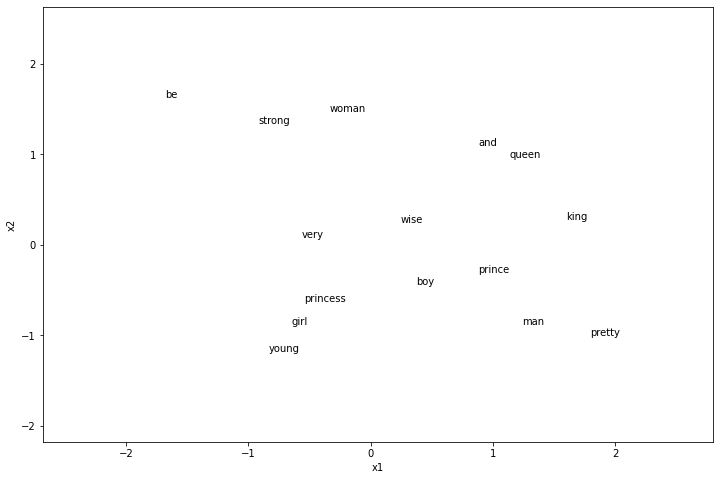

In [31]:
fig, ax = plt.subplots(figsize=(12,8))

for word, x1, x2 in zip(w2v['word'], w2v['x1'], w2v['x2']):
    ax.annotate(word, (x1, x2))
    
PADDING = 1.0
x_axis_min = np.min(word_vectors, axis=0)[0] - PADDING
y_axis_min = np.min(word_vectors, axis=0)[1] - PADDING
x_axis_max = np.max(word_vectors, axis=0)[0] + PADDING
y_axis_max = np.max(word_vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min, x_axis_max)
plt.ylim(y_axis_min, y_axis_max)
plt.xlabel('x1')
plt.ylabel('x2')

plt.show()